In [1]:
from IPython.display import Image
from IPython.display import display, HTML
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from fboost import outlier_iqr, DataPreparator, FeatureBoosterRegressor
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from ffx import FFXRegressor
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


import warnings
warnings.filterwarnings('ignore')

# Set a seed value
seed_value= 0
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

In [2]:
data = pd.read_csv('../data/raw/alldata.csv')
data.columns = ['familia','indice_fam','subposicion_1','subposicion_2','subposicion_3','subposicion_4', 'energia']
mask = (data[['subposicion_1','subposicion_2','subposicion_3','subposicion_4']] == 0).sum(axis=1) > 1
lista_train = data.loc[mask,['subposicion_1','subposicion_2','subposicion_3','subposicion_4','energia']]
lista_test = data.loc[~mask,['subposicion_1','subposicion_2','subposicion_3','subposicion_4','energia']]

In [3]:
# Instantiate the OneHotEncoder
encoder = OneHotEncoder(sparse=False, categories='auto')

X_train = lista_train.drop(['energia'], axis=1)
X_test = lista_test.drop(['energia'], axis=1)

# Fit the encoder and transform the data for both train and test dataframes
encoded_train = encoder.fit_transform(X_train)
encoded_test = encoder.transform(X_test)

# Now, 'encoded_train' and 'encoded_test' are numpy arrays, we can convert them back to dataframes:
X_train_scaled = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(X_train.columns))
X_test_scaled = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(X_test.columns))


y_test = lista_test['energia']
y_train = lista_train['energia']

In [4]:
"""
#############################################
# 4-LINEAR REGRESSION MODEL WITHFEATURE ENGINEERING #
#############################################
"""

model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)
r2_linreg_before = model_lr.score(X_test_scaled, y_test)
rmse_linreg_before = np.sqrt(mean_squared_error(y_test, model_lr.predict(X_test_scaled)))
print('LinearRegression R2 (Before feature engineering): ' + str(round(r2_linreg_before, 4)))
print('LinearRegression RMSE (Before feature engineering): ' + str(round(rmse_linreg_before, 4)))

LinearRegression R2 (Before feature engineering): 0.3361
LinearRegression RMSE (Before feature engineering): 3.7005


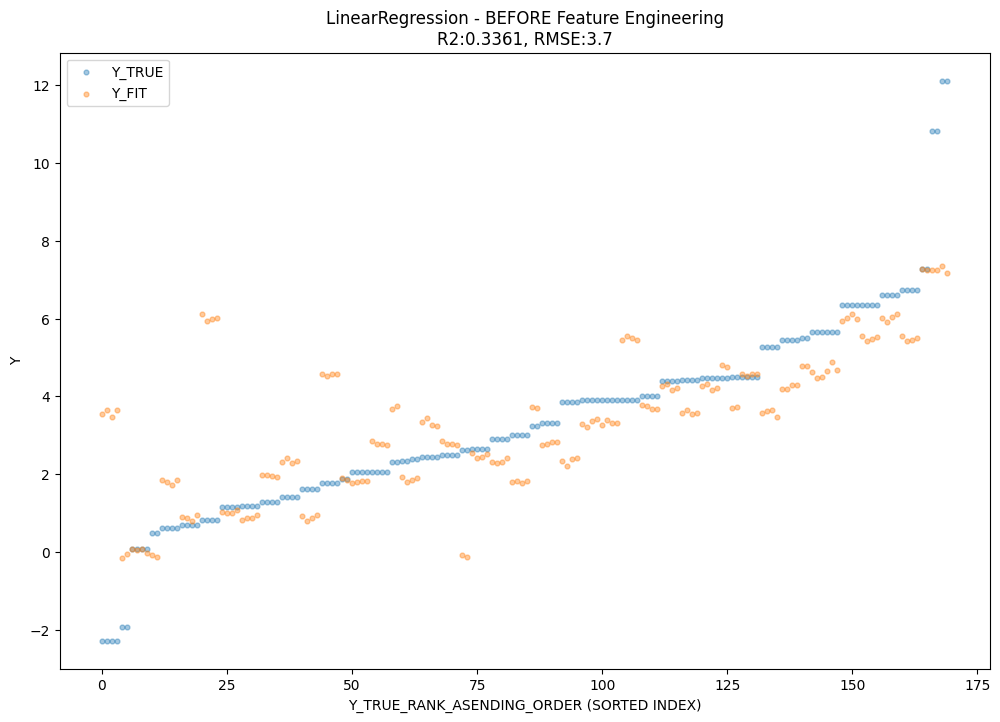

In [5]:
fit_results = pd.DataFrame(y_train.copy())
fit_results.columns = ['Y_TRUE']
test_pred_results = pd.DataFrame(y_test.copy())
test_pred_results.columns = ['Y_TRUE']

fit_results['Y_FIT'] = model_lr.predict(X_train_scaled).ravel()
test_pred_results['Y_PRED'] = model_lr.predict(X_test_scaled)

fit_results = fit_results.sort_values(by = ['Y_TRUE']).reset_index(drop = True)
test_pred_results = test_pred_results.sort_values(by = ['Y_TRUE']).reset_index(drop = True)

#### SCATTER PLOT
plt.figure(figsize=(12,8))
plt.scatter(fit_results.index,  fit_results['Y_TRUE'], alpha = 0.4, s = 12, label = 'Y_TRUE')
plt.scatter(fit_results.index,  fit_results['Y_FIT'], alpha = 0.4, s = 12, label = 'Y_FIT')
plt.xlabel('Y_TRUE_RANK_ASENDING_ORDER (SORTED INDEX)')
plt.ylabel('Y')
plt.title('LinearRegression - BEFORE Feature Engineering' + '\n' + 'R2:' + str(round(r2_linreg_before, 4)) + ', RMSE:' + str(round(rmse_linreg_before, 2)))
plt.legend()

In [6]:

# assuming df is your DataFrame
df = lista_train.drop(['energia'], axis=1)

# replace zeros with np.nan
df = df.replace(0, np.nan)

# instantiate OneHotEncoder
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')

# apply OneHotEncoder to df
onehot_df = enc.fit_transform(df)

# create H matrix
H = np.zeros(df.shape)

# specify the position of non-zero values in H
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        if not np.isnan(df.iloc[i, j]):
            H[i, j] = j+1  # or just 1, based on your requirements



In [7]:

X_train_array = np.concatenate((onehot_df, H), axis=1)
X_train_encoded = X_train_array.reshape((X_train_array.shape[0], X_train_array.shape[1], 1))

input_shape_train = (X_train_encoded.shape[1],1)
# assuming onehot_df_encoded and H are your input data and are numpy arrays
# reshape data for Conv1D, the format should be (n_samples, steps, channels)
onehot_df_encoded = onehot_df.reshape((170, 24, 1))
H_encoded = H.reshape((170, 4, 1))

# target data
y_train = np.array(y_train)
input_shape_train

(28, 1)

In [8]:
# assuming df is your DataFrame
df_test = lista_test.drop(['energia'], axis=1)

# replace zeros with np.nan
df_test = df_test.replace(0, np.nan)

# instantiate OneHotEncoder
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')

# apply OneHotEncoder to df
onehot_df_test = enc.fit_transform(df_test)

# create H matrix
H_test = np.zeros(df_test.shape)

# specify the position of non-zero values in H
for i in range(df_test.shape[0]):
    for j in range(df_test.shape[1]):
        if not np.isnan(df_test.iloc[i, j]):
            H_test[i, j] = j+1  # or just 1, based on your requirements


In [9]:
onehot_df_test_encoded = onehot_df_test.reshape((onehot_df_test.shape[0], 24, 1))
H_test_encoded = H_test.reshape((H_test.shape[0], 4, 1))

X_test_array = np.concatenate((onehot_df_test, H_test), axis=1)
X_test_encoded = X_test_array.reshape((X_test_array.shape[0], X_test_array.shape[1], 1))
input_shape_test = (X_test_encoded.shape[1],1)
# target data
y_test = np.array(y_test)
y_test.shape

(1120,)

In [10]:
model_lr_encoded = LinearRegression()
model_lr_encoded.fit(X_train_array, y_train)

# Get predictions
preds_lr_encoded = model_lr_encoded.predict(X_test_array)

# You can evaluate your predictions using a suitable error metric from sklearn.metrics
# For example:
mse_lr_encoded = mean_squared_error(y_test, preds_lr_encoded)
rmse_lr_encoded = np.sqrt(mse_lr_encoded)
mae_lr_encoded = mean_absolute_error(y_test, preds_lr_encoded)
r2_lr_encoded = r2_score(y_test, preds_lr_encoded)

print('Mean Squared Error (MSE_lr_encoded): ', mse_lr_encoded)
print('Root Mean Squared Error (RMSE_lr_encoded): ', rmse_lr_encoded)
print('Mean Absolute Error (MAE_lr_encoded): ', mae_lr_encoded)
print('R-squared Score (R^2_lr_encoded): ', r2_lr_encoded)

Mean Squared Error (MSE_lr_encoded):  13.650688067299626
Root Mean Squared Error (RMSE_lr_encoded):  3.6946837574141074
Mean Absolute Error (MAE_lr_encoded):  2.488588204899554
R-squared Score (R^2_lr_encoded):  0.33815099083001865


In [11]:
from catboost import CatBoostRegressor, Pool

# Identify the indices of the categorical features
cat_features_indices = np.where(X_train.dtypes != np.float)[0]

X_train_cat, X_eval_cat, y_train_cat, y_eval_cat = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Initialize CatBoostRegressor
model_cat = CatBoostRegressor(
    iterations=500,
    depth=10,
    learning_rate=0.01,
    loss_function='RMSE',
    custom_metric=['RMSE'],
    random_seed=42,
    logging_level='Silent',
)

# Fit model
model_cat.fit(
    X_train_cat, y_train_cat,
    cat_features=cat_features_indices,
    eval_set=(X_eval_cat, y_eval_cat),
    use_best_model=True
)

# Get predictions
preds_cat = model_cat.predict(X_test)

# You can evaluate your predictions using a suitable error metric from sklearn.metrics
# For example:
mse_cat = mean_squared_error(y_test, preds_cat)
rmse_cat = np.sqrt(mse_cat)
mae_cat = mean_absolute_error(y_test, preds_cat)
r2_cat = r2_score(y_test, preds_cat)

print('Mean Squared Error (MSE_cat): ', mse_cat)
print('Root Mean Squared Error (RMSE_cat): ', rmse_cat)
print('Mean Absolute Error (MAE_cat): ', mae_cat)
print('R-squared Score (R^2_cat): ', r2_cat)


Mean Squared Error (MSE_cat):  28.928039516404937
Root Mean Squared Error (RMSE_cat):  5.378479294038877
Mean Absolute Error (MAE_cat):  3.5184462955835274
R-squared Score (R^2_cat):  -0.40256624404355956


In [12]:
# Identify the indices of the categorical features
cat_features_indices_scaled = np.where(X_train_scaled.dtypes != np.float)[0]

X_train_cat_scaled, X_eval_cat_scaled, y_train_cat_scaled, y_eval_cat_scaled = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# Initialize CatBoostRegressor
model_cat_scaled = CatBoostRegressor(
    iterations=500,
    depth=10,
    learning_rate=0.01,
    loss_function='RMSE',
    custom_metric=['RMSE'],
    random_seed=42,
    logging_level='Silent',
)

# Fit model
model_cat_scaled.fit(
    X_train_cat_scaled, y_train_cat_scaled,
    cat_features=cat_features_indices_scaled,
    eval_set=(X_eval_cat_scaled, y_eval_cat_scaled),
    use_best_model=True
)

# Get predictions
preds_cat_scaled = model_cat_scaled.predict(X_test_scaled)

# You can evaluate your predictions using a suitable error metric from sklearn.metrics
# For example:
mse_cat_scaled = mean_squared_error(y_test, preds_cat_scaled)
rmse_cat_scaled = np.sqrt(mse_cat_scaled)
mae_cat_scaled = mean_absolute_error(y_test, preds_cat_scaled)
r2_cat_scaled = r2_score(y_test, preds_cat_scaled)

print('Mean Squared Error (MSE_cat): ', mse_cat_scaled)
print('Root Mean Squared Error (RMSE_cat): ', rmse_cat_scaled)
print('Mean Absolute Error (MAE_cat): ', mae_cat_scaled)
print('R-squared Score (R^2_cat): ', r2_cat_scaled)

Mean Squared Error (MSE_cat):  27.44216441005701
Root Mean Squared Error (RMSE_cat):  5.238526931309699
Mean Absolute Error (MAE_cat):  3.440668321387248
R-squared Score (R^2_cat):  -0.33052409041450415


In [13]:
from sklearn.preprocessing import PolynomialFeatures

# assuming X_train is your training data
poly = PolynomialFeatures(16)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

model_lr_poly = LinearRegression()
model_lr_poly.fit(X_train_poly, y_train)

# Get predictions
preds_lr_poly = model_lr_poly.predict(X_test_poly)

# You can evaluate your predictions using a suitable error metric from sklearn.metrics
# For example:
mse_lr_poly = mean_squared_error(y_test, preds_lr_poly)
rmse_lr_poly = np.sqrt(mse_lr_poly)
mae_lr_poly = mean_absolute_error(y_test, preds_lr_poly)
r2_lr_poly = r2_score(y_test, preds_lr_poly)

print('Mean Squared Error (MSE_lr_poly): ', mse_lr_poly)
print('Root Mean Squared Error (RMSE_lr_poly): ', rmse_lr_poly)
print('Mean Absolute Error (MAE_lr_poly): ', mae_lr_poly)
print('R-squared Score (R^2_lr_poly): ', r2_lr_poly)

Mean Squared Error (MSE_lr_poly):  9.102522057629624
Root Mean Squared Error (RMSE_lr_poly):  3.0170386238213167
Mean Absolute Error (MAE_lr_poly):  2.0448024032908725
R-squared Score (R^2_lr_poly):  0.5586672865800947


In [14]:
# This can be done with PolynomialFeatures by setting interaction_only=True
inter = PolynomialFeatures(32, interaction_only=True)
X_train_inter = inter.fit_transform(X_train)
X_test_inter = inter.fit_transform(X_test)

model_lr_inter = LinearRegression()
model_lr_inter.fit(X_train_inter, y_train)

# Get predictions
preds_lr_inter = model_lr_inter.predict(X_test_inter)

# You can evaluate your predictions using a suitable error metric from sklearn.metrics
# For example:
mse_lr_inter = mean_squared_error(y_test, preds_lr_inter)
rmse_lr_inter = np.sqrt(mse_lr_inter)
mae_lr_inter = mean_absolute_error(y_test, preds_lr_inter)
r2_lr_inter = r2_score(y_test, preds_lr_inter)

print('Mean Squared Error (MSE_lr_inter): ', mse_lr_inter)
print('Root Mean Squared Error (RMSE_lr_inter): ', rmse_lr_inter)
print('Mean Absolute Error (MAE_lr_inter): ', mae_lr_inter)
print('R-squared Score (R^2_lr_inter): ', r2_lr_inter)


Mean Squared Error (MSE_lr_inter):  18.208129911045308
Root Mean Squared Error (RMSE_lr_inter):  4.267098535427241
Mean Absolute Error (MAE_lr_inter):  3.025792913858434
R-squared Score (R^2_lr_inter):  0.11718495939175255


In [15]:
from sklearn.preprocessing import KBinsDiscretizer

# Discretize continuous features into 5 bins
kb = KBinsDiscretizer(n_bins=44, strategy='uniform', encode='onehot-dense')
X_train_binned = kb.fit_transform(X_train)
X_test_binned = kb.fit_transform(X_test)

model_lr_binned = LinearRegression()
model_lr_binned.fit(X_train_binned, y_train)

# Get predictions
preds_lr_binned = model_lr_binned.predict(X_test_binned)

# You can evaluate your predictions using a suitable error metric from sklearn.metrics
# For example:
mse_lr_binned = mean_squared_error(y_test, preds_lr_binned)
rmse_lr_binned = np.sqrt(mse_lr_binned)
mae_lr_binned = mean_absolute_error(y_test, preds_lr_binned)
r2_lr_binned = r2_score(y_test, preds_lr_binned)

print('Mean Squared Error (MSE_lr_binned): ', mse_lr_binned)
print('Root Mean Squared Error (RMSE_lr_binned): ', rmse_lr_binned)
print('Mean Absolute Error (MAE_lr_binned): ', mae_lr_binned)
print('R-squared Score (R^2_lr_binned): ', r2_lr_binned)


Mean Squared Error (MSE_lr_binned):  13.779597704008822
Root Mean Squared Error (RMSE_lr_binned):  3.7120880517585815
Mean Absolute Error (MAE_lr_binned):  2.527925883928572
R-squared Score (R^2_lr_binned):  0.33190085055080254


In [38]:
# Instantiate the OneHotEncoder
encoder = OneHotEncoder(sparse=False, categories='auto')

X_train = lista_train.drop(['energia'], axis=1)
X_test = lista_test.drop(['energia'], axis=1)

# Fit the encoder and transform the data for both train and test dataframes
encoded_train = encoder.fit_transform(X_train)
encoded_test = encoder.transform(X_test)

# Now, 'encoded_train' and 'encoded_test' are numpy arrays, we can convert them back to dataframes:
X_train_scaled = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(X_train.columns))
X_test_scaled = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(X_test.columns))


y_test = pd.DataFrame(lista_test['energia'])
y_train = pd.DataFrame(lista_train['energia'])

feature_names = list(X_train_scaled.columns.difference(['energia']))

y_test


,energia
76,6.161766
77,6.161766
78,6.161766
79,6.161766
80,3.911919
...,...
1285,5.962984
1286,6.108256
1287,6.108256
1288,6.108256


In [39]:


# FEATURE ENGINEERING - 1/2 - Polynomials + Rules extraction
fboost = FeatureBoosterRegressor(base_model = RandomForestRegressor(criterion='friedman_mse', 
                                                    max_depth=5,
                                                    max_features=None, 
                                                    max_leaf_nodes=2,
                                                    min_samples_leaf=1, 
                                                    verbose=0, 
                                                    n_estimators = 850,
                                                    warm_start=True,
                                                    random_state = 0),
                                max_rules = 2800, 
                                n_best_rules = 35,
                                original_features_selection= False,
                                selection_strategy = 'severe',  
                                quantile_cutoff = 0.83,
                                alpha = 89,
                                scaler = 'Standard',
                                random_state = 0)

# FIT FEATURE ENGINEERING FOR TRAIN DATA
X_train_fb, rules = fboost.fit_transform(X_train_scaled, y_train)

# TRANSFORM FEATURE ENGINEERING FOR TEST DATA
X_test_fb = fboost.transform(X_test_scaled)

ValueError: DataFrame constructor not properly called!

In [ ]:
#LET HAVE A LOOK AT THE NEW FEATURES WE JUST CREATED
X_train_fb.info()